# PBD Wine Data
A. Ilbay - 2798233,
B. Yalçın - 2797623,
Ç. Pınarbaşı - 2658187,
D. Gülal - 2797094.

In [13]:
import numpy as np
import pandas as pd
import sklearn
import gensim
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import os
warnings.filterwarnings("ignore")

## Read the data

In [14]:
data = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
data2 = pd.read_csv('winemag-data_first150k.csv', index_col=0)
merged_data = pd.concat([data, data2], ignore_index=True)
data = merged_data
data = data.drop(['taster_name', 'taster_twitter_handle'], axis=1)
data.head()

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Preprocessing and correlation matrix

In [15]:
desc = data.copy()

for column_name in desc.columns:
    if column_name != "points" and column_name != "price":
        desc[column_name] = desc[column_name].astype(str).map(lambda x: x.lower())

In [16]:
from nltk.stem import SnowballStemmer
import gensim
from gensim.parsing.preprocessing import STOPWORDS

def remove_stopwords_into_array(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 1:
            result.append(token)
    return result

def stemmize_array(text):
    stemmer = SnowballStemmer("english")
    result = []
    for token in text:
        result.append(stemmer.stem(token))
    
    return result

def stringize_array(array):
    return ' '.join(array)

#Create processed.csv if it doesn't exist
if not os.path.isfile('processed.csv'):
    for column_name in desc.columns:
        desc[column_name] = desc[column_name].astype(str).map(remove_stopwords_into_array)
        desc[column_name] = desc[column_name].map(stemmize_array)
        desc[column_name] = desc[column_name].map(stringize_array)
        desc.drop([column_name],axis=1).to_csv('processed.csv')


desc = pd.read_csv('processed.csv')
desc = desc.drop(desc.columns[0], axis=1)

Text(0.5, 1.0, 'Correlation Matrix')

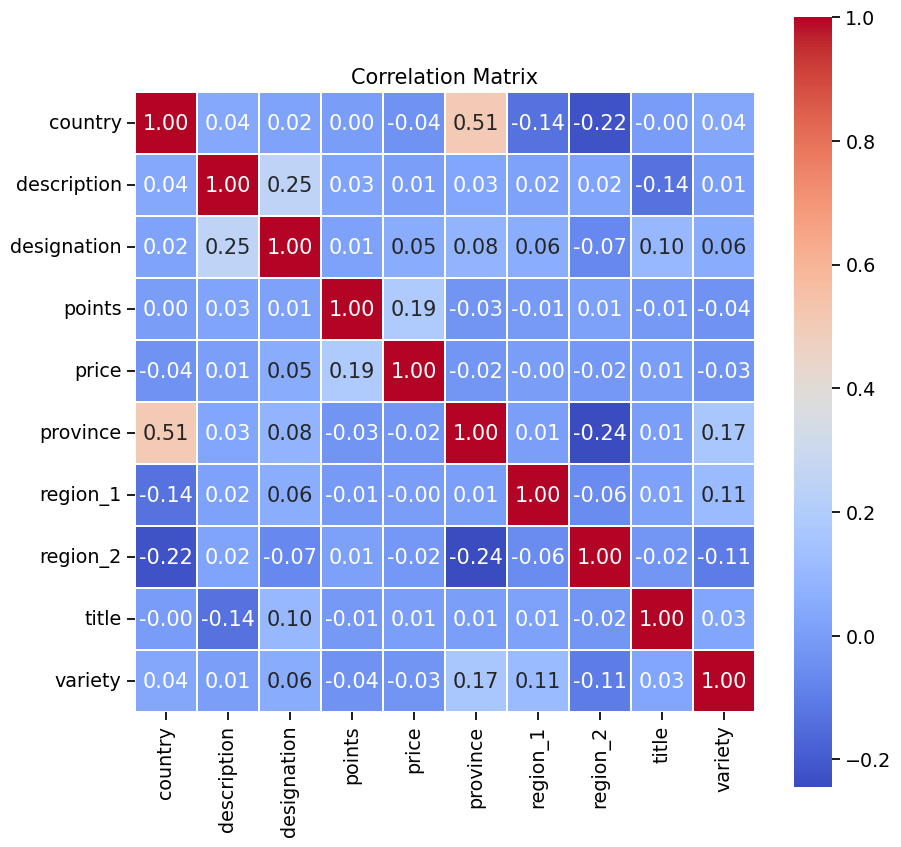

In [17]:
import nltk

# fill the price and points columns with data from the original dataframe
desc['price'] = data['price']
desc['points'] = data['points']

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(desc.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), square=True, annot=True, cmap='coolwarm', linewidths=0.2, fmt=".2f", ax=plt.subplots(figsize=(10,10))[1]).set_title('Correlation Matrix')


## Word Data

### Get most common 30 words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(desc['description'])

In [19]:
words = count_vectorizer.get_feature_names_out()
total_counts = np.zeros(len(words))
for t in count_data:
    total_counts+=t.toarray()[0]

In [20]:
count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

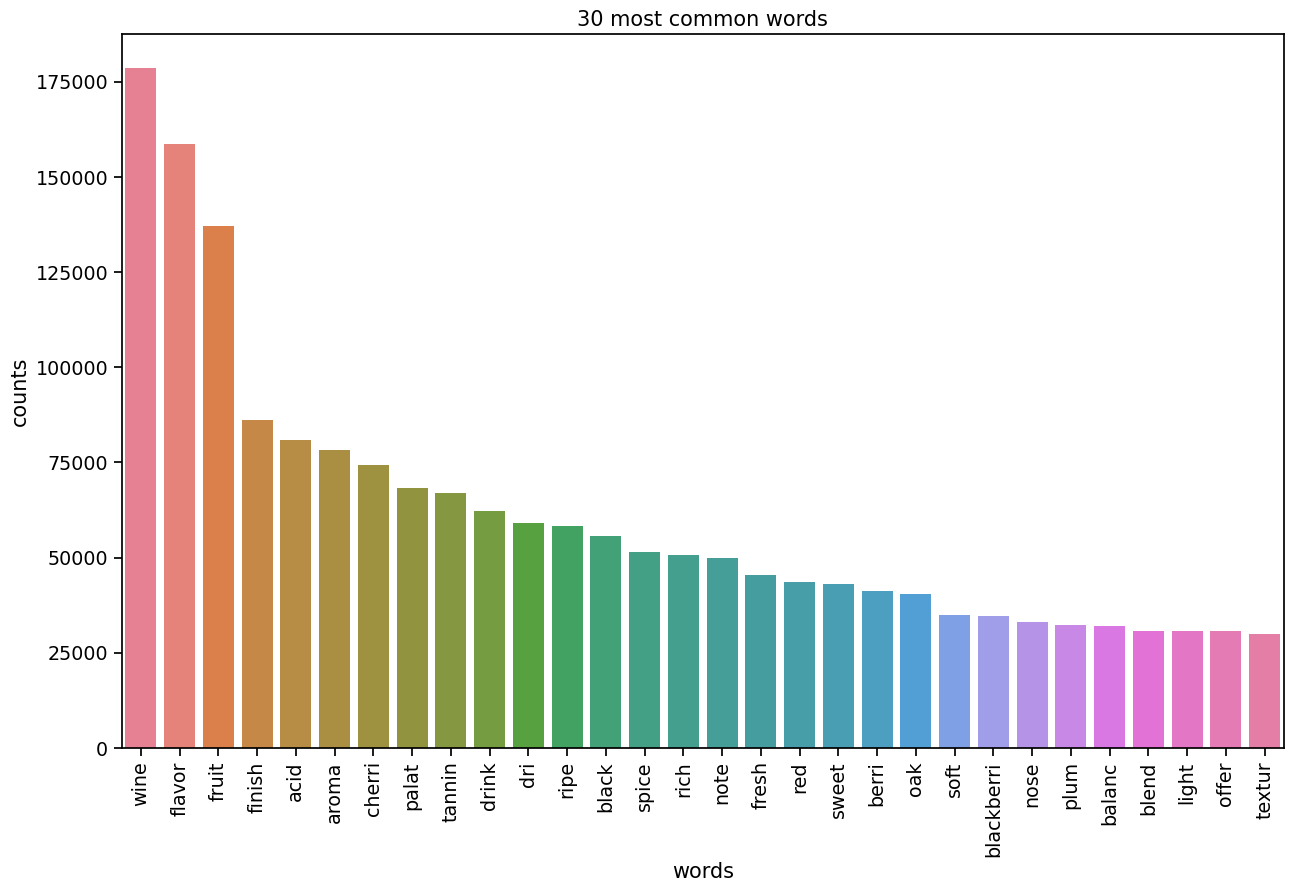

,0
count,25878.000000
mean,255.331092
std,2701.473799
min,1.000000
25%,2.000000
50%,4.000000
75%,19.000000
max,178572.000000


In [21]:
plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='30 most common words')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x=x_pos[0:30], y=counts[0:30], palette='husl')
plt.xticks(x_pos[0:30], words[0:30], rotation=90) 
plt.xlabel('words')
plt.ylabel('counts')
plt.show()
pd.DataFrame(counts).describe()

### Generate wordcloud

In [22]:
words[:10]

['wine',
 'flavor',
 'fruit',
 'finish',
 'acid',
 'aroma',
 'cherri',
 'palat',
 'tannin',
 'drink']

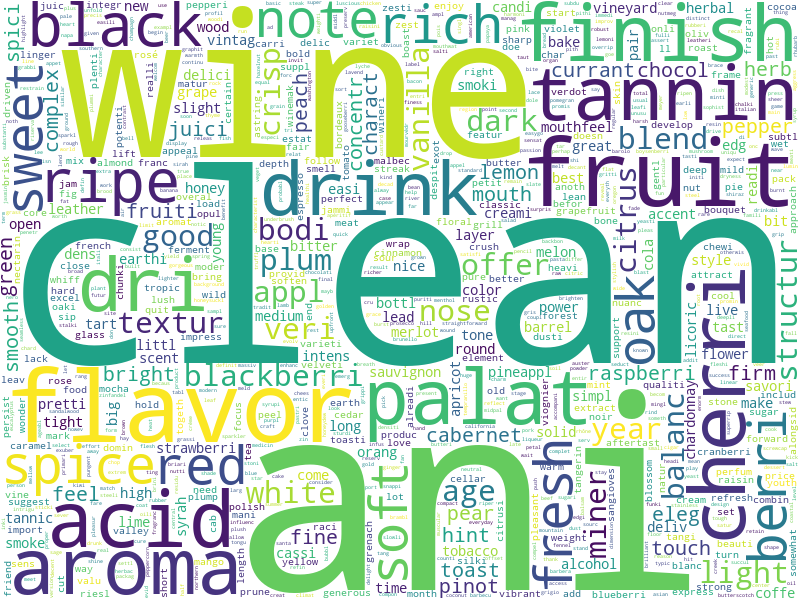

In [23]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, width=800, height=600)#, contour_width=3, contour_color='steelblue')

# words.remove('dimen')

wordcloud.generate(" ".join(words[:1000]))

wordcloud.to_image()

### LDA

In [24]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
wine fruit age acid tannin ripe drink rich flavor year

Topic #1:
flavor wine acid appl finish fruit citrus fresh crisp palat

Topic #2:
flavor cherri wine blackberri tannin black cabernet dri rich oak

Topic #3:
aroma palat cherri wine spice fruit offer note black tannin

Topic #4:
flavor finish aroma fruit palat berri plum cherri nose note


### Clustering

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=1, # in how many documents the term minimally occurs
                            max_df=0.4,
                            tokenizer=nltk.word_tokenize)

X_train = tfidf.fit_transform(desc.description)

In [26]:
from sklearn.cluster import KMeans
model = KMeans()
model.fit(X_train)

KMeans()

Get representative from each cluster

In [27]:
df = pd.DataFrame(desc.description,model.labels_).reset_index(names = ['cluster'])
df.groupby('cluster').first()

,description
cluster,
0,aroma includ tropic fruit broom brimston and d...
1,this is ripe and fruiti wine that is smooth wh...
2,tart and snappi the flavor of lime flesh and r...
3,pineappl rind lemon pith and orang blossom sta...
4,much like the regular bottl from this come acr...
5,blackberri and raspberri aroma show typic nava...
6,here bright inform red that open with aroma of...
7,this dri and restrain wine offer spice in prof...


# Training Models

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc.description, desc.points, test_size = 0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

## Description --> Points linear regression

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

tfidf_vectorizer = TfidfVectorizer(min_df=1, # in how many documents the term minimally occurs
                            max_df=0.4,
                            tokenizer=nltk.word_tokenize)

model = LinearRegression()
clfidf = Pipeline( [
    ('vectorizer', tfidf_vectorizer),
    ('nb', model)
])

In [18]:
clfidf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.4,
                                 tokenizer=<function word_tokenize at 0x00000189A0AEA4D0>)),
                ('nb', LinearRegression())])

In [19]:
y_pred = clfidf.predict(X_valid)

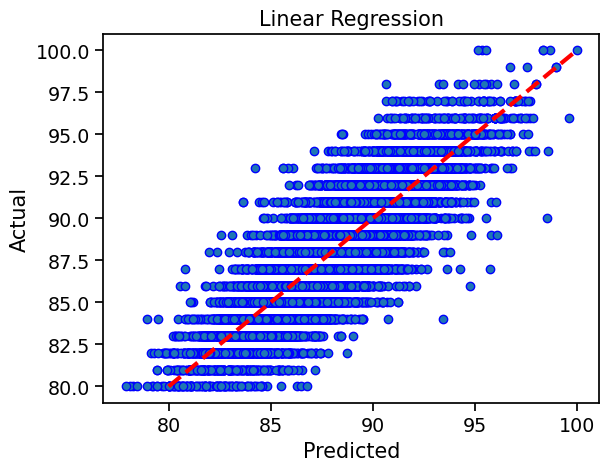

In [20]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_valid, edgecolors=(0, 0, 1))
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Linear Regression')
plt.show()

In [21]:
# model evaluation for testing set
from sklearn import metrics
mae = metrics.mean_absolute_error(y_valid, y_pred)
mse = metrics.mean_squared_error(y_valid, y_pred)
r2 = metrics.r2_score(y_valid, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
# print accuracy
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(clfidf.score(X_valid, y_valid)))

The model performance for testing set
--------------------------------------
MAE is 1.2628210494548147
MSE is 2.736613432412304
R2 score is 0.7241665054361166
Accuracy of linear regression classifier on test set: 0.72


## Description --> points

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc.description, desc.points, test_size = 0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

## Random Forest TF-IDF

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.ensemble import RandomForestClassifier
tfidf_vectorizer = TfidfVectorizer(min_df=1, # in how many documents the term minimally occurs
                            max_df=0.3,
                            tokenizer=nltk.word_tokenize)

model = RandomForestClassifier(max_depth=250,verbose=True)
clfidf = Pipeline( [
    ('vectorizer', tfidf_vectorizer),
    ('nb', model)
])

In [31]:
clfidf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 37.4min finished


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.3,
                                 tokenizer=<function word_tokenize at 0x0000018054CC64D0>)),
                ('nb', RandomForestClassifier(max_depth=250, verbose=True))])

In [32]:
y_pred = clfidf.predict(X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_valid, y_pred)

In [ ]:
print(report)

              precision    recall  f1-score   support

          80       0.99      0.62      0.76       117
          81       1.00      0.66      0.80       196
          82       0.85      0.71      0.77       554
          83       0.90      0.63      0.74       793
          84       0.77      0.69      0.73      1561
          85       0.77      0.68      0.72      1921
          86       0.71      0.69      0.70      2526
          87       0.57      0.78      0.66      3366
          88       0.57      0.72      0.63      3068
          89       0.82      0.60      0.69      2199
          90       0.56      0.73      0.64      2911
          91       0.72      0.62      0.67      2029
          92       0.71      0.62      0.66      1726
          93       0.85      0.55      0.67      1149
          94       0.97      0.55      0.70       674
          95       1.00      0.55      0.71       289
          96       1.00      0.59      0.74       114
          97       1.00    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


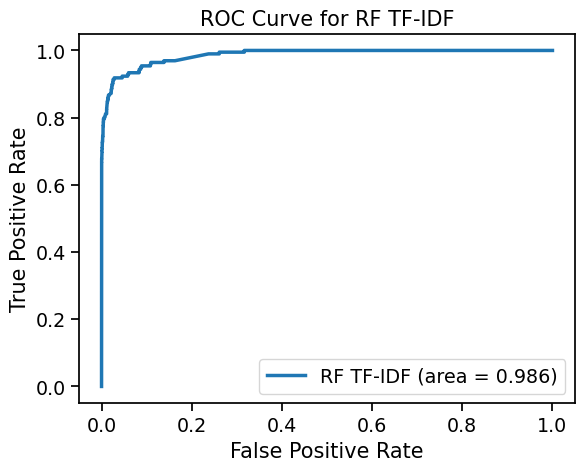

In [ ]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_rfidf = clfidf.predict_proba(X_valid)[:,1]

curve_rfidf = roc_curve(y_valid, y_rfidf, pos_label=clfidf.classes_[1])

auc_rfidf = auc(curve_rfidf[0], curve_rfidf[1])

rfidfplot = plt.plot(curve_rfidf[0], curve_rfidf[1], label='RF TF-IDF (area = %0.3f)'% auc_rfidf)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF TF-IDF')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

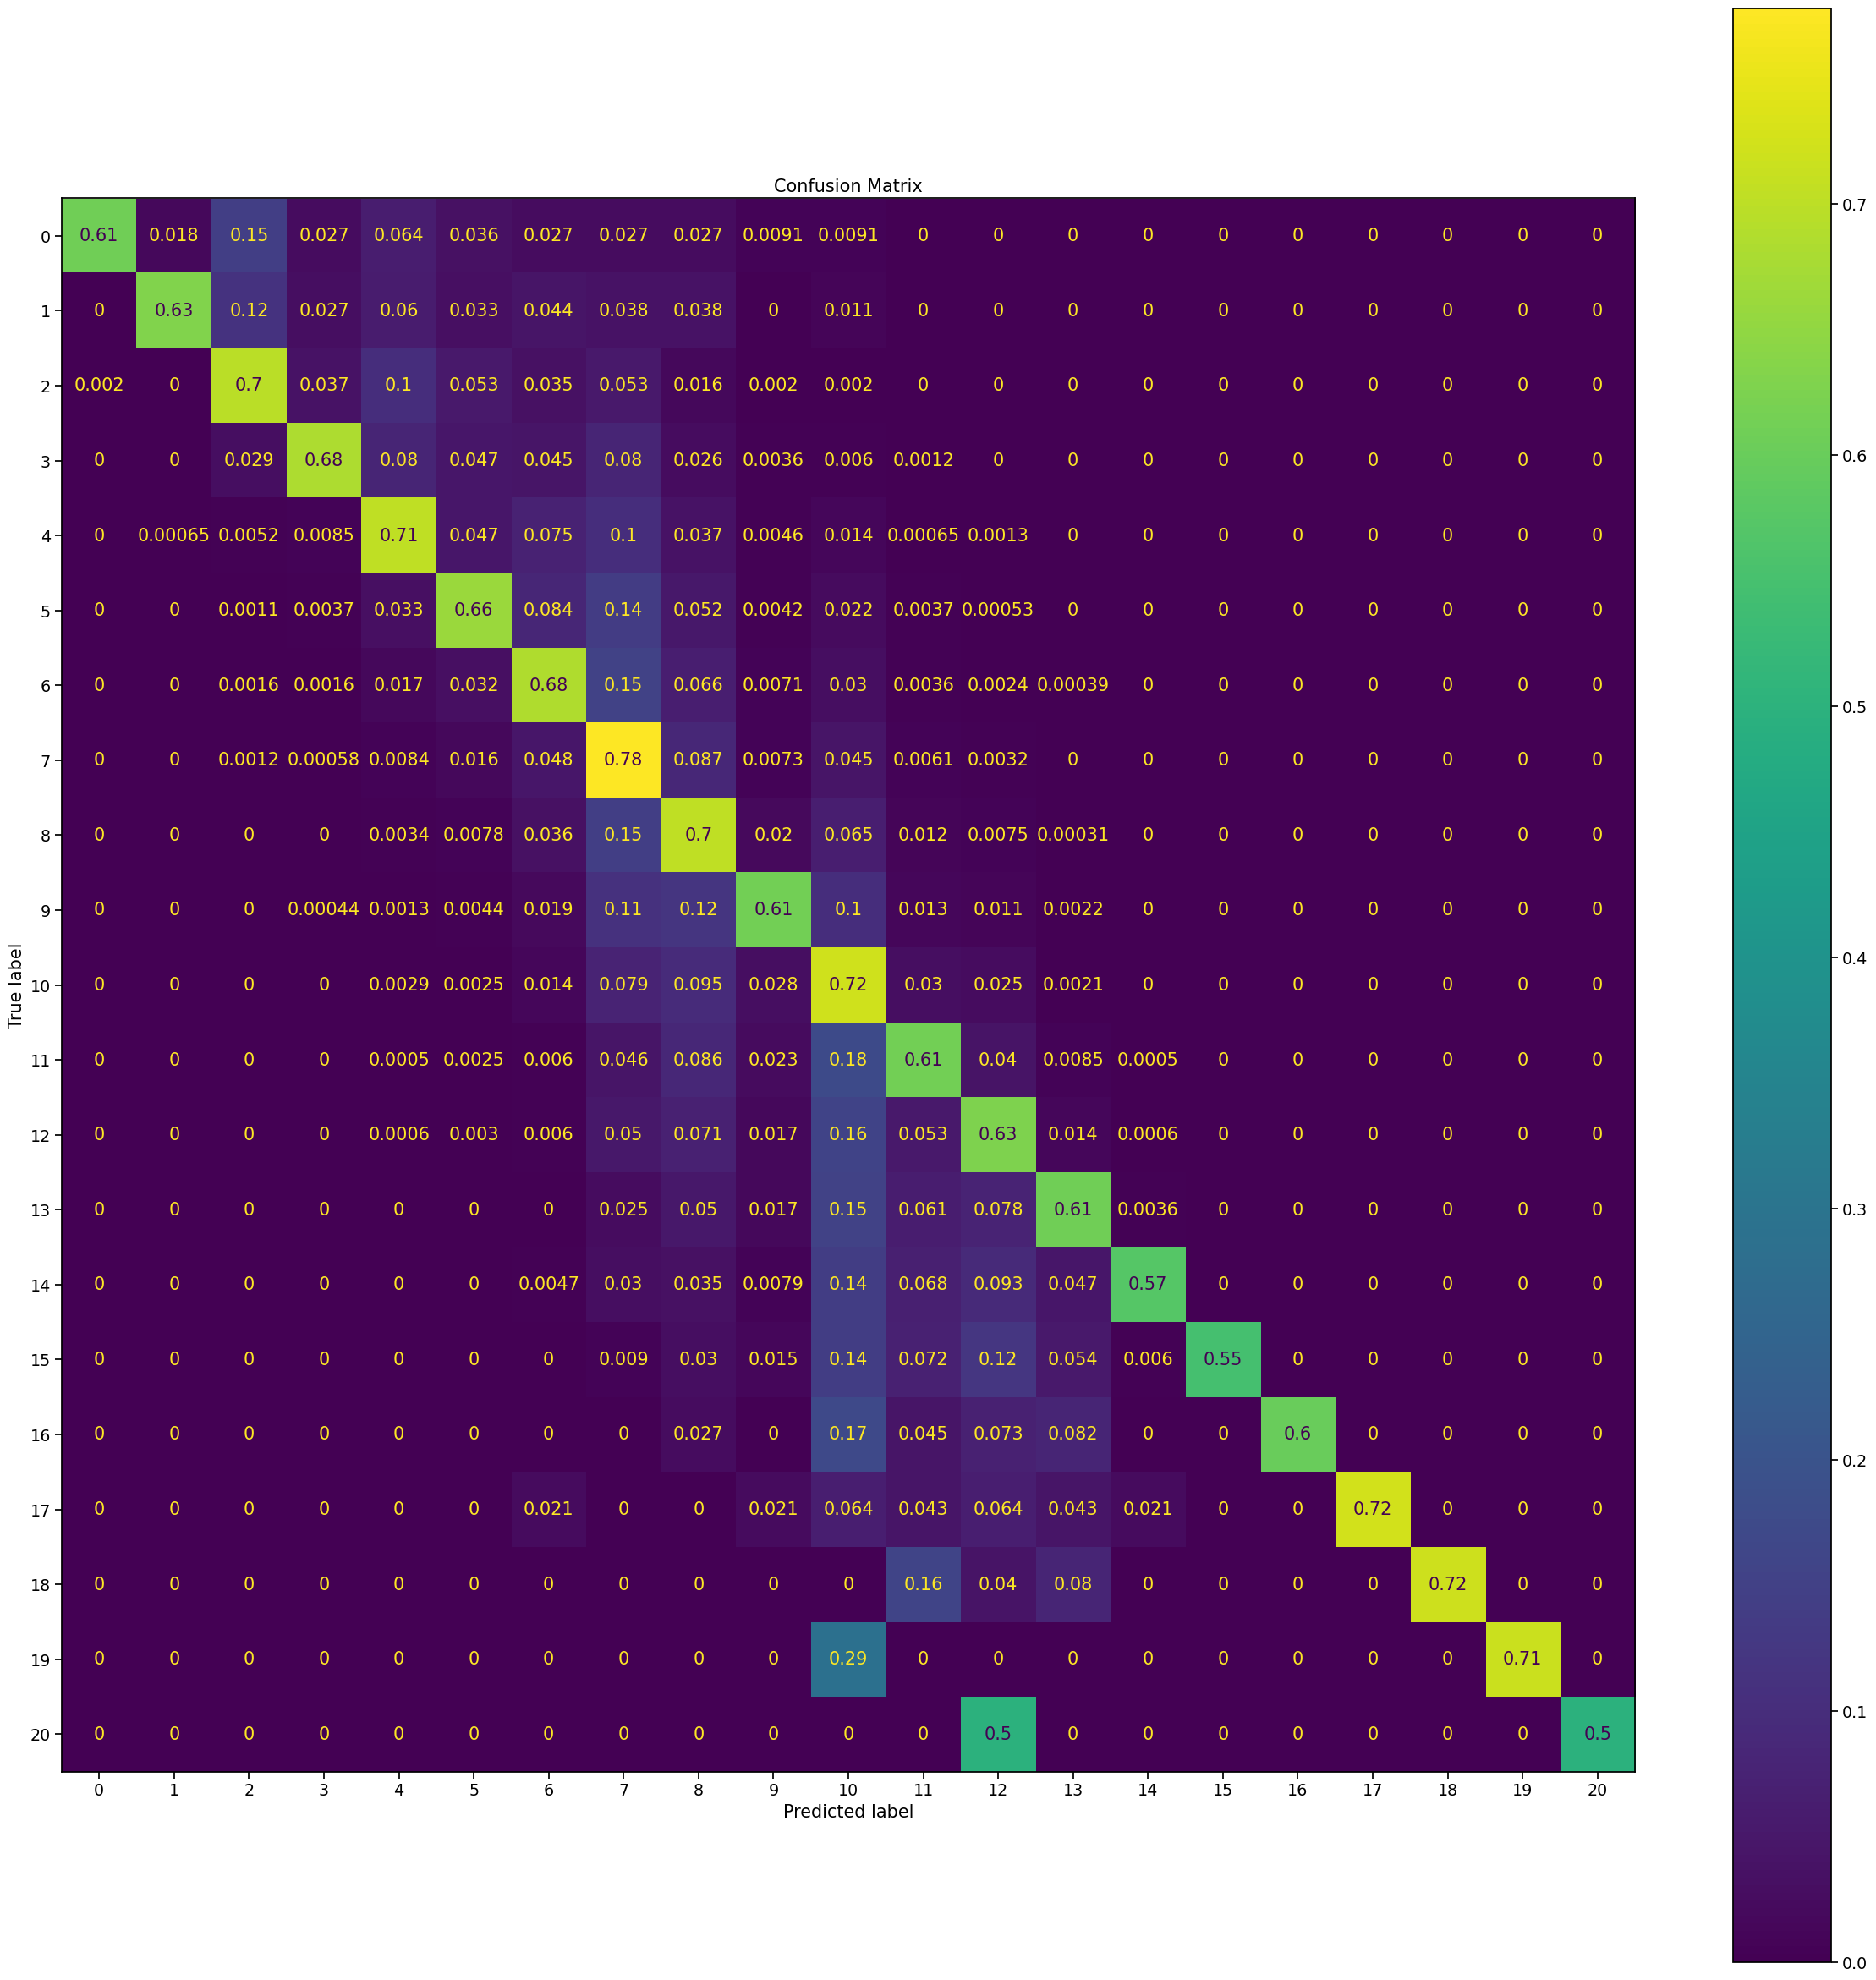

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# plot confusion matrix
confusion_matrix(y_valid, y_pred, normalize='true')

# confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred, normalize='true')).plot()
plt.gcf().set_size_inches(30, 30)
#limit to 2 decimal places
plt.grid(False)
cm_display.ax_.set_title('Confusion Matrix')

## Gradient boost

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc.description, desc.points, test_size = 0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

tfidf_vectorizer = TfidfVectorizer(min_df=1, # in how many documents the term minimally occurs
                            max_df=0.3,
                            tokenizer=nltk.word_tokenize)

model = GradientBoostingClassifier(max_depth=3,verbose=True, learning_rate=0.001)
clfidf = Pipeline( [
    ('vectorizer', tfidf_vectorizer),
    ('nb', model)
])

In [31]:
clfidf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.5551          133.41m
         2           2.5547          133.81m
         3           2.5543          132.98m
         4           2.5540          131.68m
         5           2.5537          130.09m
         6           2.5534          128.49m
         7           2.5530          127.28m
         8           2.5527          125.40m
         9           2.5524          123.74m
        10           2.5522          122.21m
        20           2.5494          109.50m
        30           2.5469           95.50m
        40           2.5446           81.56m
        50           2.5425           67.27m
        60           2.5403           52.84m
        70           2.5383           39.38m
        80           2.5364           26.24m
        90           2.5346           13.14m
       100           2.5327            0.00s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.3,
                                 tokenizer=<function word_tokenize at 0x00000189A0AEA4D0>)),
                ('nb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            verbose=True))])

In [32]:
y_pred = clfidf.predict(X_valid)

In [33]:
from sklearn.metrics import classification_report
report = classification_report(y_valid, y_pred,  zero_division=1)

In [34]:
print(report)

              precision    recall  f1-score   support

          80       1.00      0.00      0.00       103
          81       1.00      0.00      0.00       178
          82       1.00      0.00      0.00       578
          83       1.00      0.00      0.00       851
          84       1.00      0.00      0.00      1548
          85       0.22      0.00      0.00      1978
          86       1.00      0.00      0.00      2454
          87       0.14      0.99      0.24      3536
          88       0.21      0.01      0.03      3137
          89       0.00      0.00      0.00      2184
          90       1.00      0.00      0.00      2817
          91       1.00      0.00      0.00      2000
          92       1.00      0.00      0.00      1714
          93       1.00      0.00      0.00      1081
          94       1.00      0.00      0.00       630
          95       1.00      0.00      0.00       295
          96       1.00      0.00      0.00       111
          97       1.00    

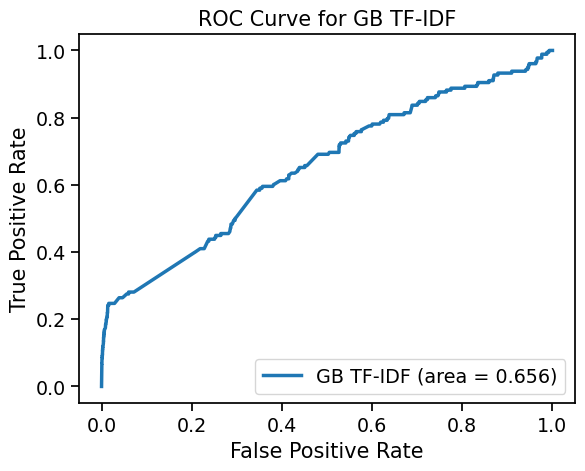

In [35]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_gbidf = clfidf.predict_proba(X_valid)[:,1]

curve_gbidf = roc_curve(y_valid, y_gbidf, pos_label=clfidf.classes_[1])

auc_gbidf = auc(curve_gbidf[0], curve_gbidf[1])

rfidfplot = plt.plot(curve_gbidf[0], curve_gbidf[1], label='GB TF-IDF (area = %0.3f)'% auc_gbidf)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GB TF-IDF')
plt.legend(loc="lower right")
plt.show()

## Merged ROC curve

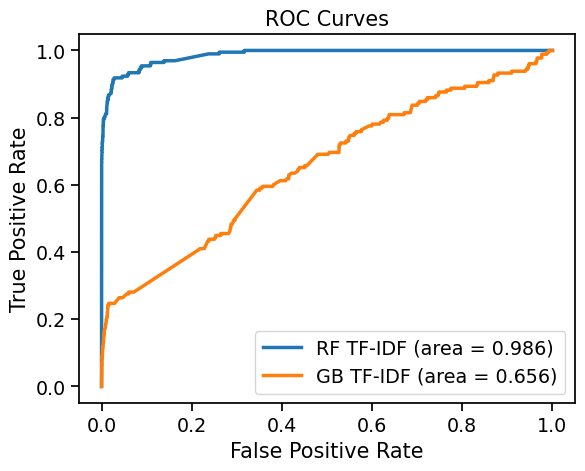

In [36]:
plt.plot(curve_rfidf[0], curve_rfidf[1], label='RF TF-IDF (area = %0.3f)'% auc_rfidf)
plt.plot(curve_gbidf[0], curve_gbidf[1], label='GB TF-IDF (area = %0.3f)'% auc_gbidf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

# Wine Varieties

## Regions with highest number of varieties.

,num_var
count,1332.000000
mean,6.399399
std,10.066552
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,86.000000


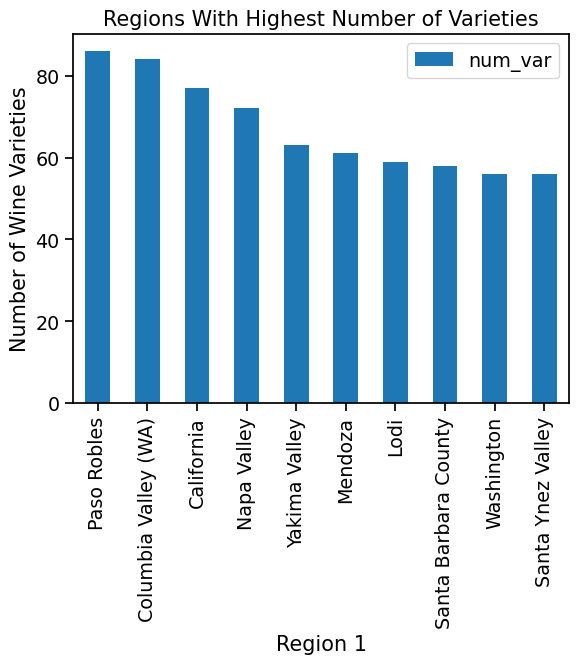

In [37]:
df = data[["region_1","variety"]]
df = df.groupby(["region_1"])
distinc_varieties = df['variety'].unique()
df = pd.DataFrame(distinc_varieties)
df['num_var'] = df['variety'].apply(lambda x:len(x))
df = df.sort_values(["num_var"],ascending=False)

bp = df[:10].plot.bar()

bp.set_title("Regions With Highest Number of Varieties")
bp.set_xlabel("Region 1")
bp.set_ylabel("Number of Wine Varieties")

df.describe()

## Distribution of Number of Varieties

Text(0, 0.5, 'Number of Regions')

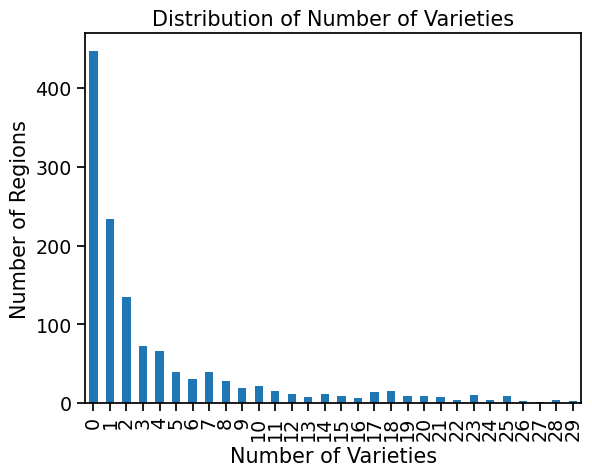

In [38]:
regions = df.reset_index()[['region_1','num_var']]
bpp = regions['num_var'].value_counts().reset_index().sort_values(['index'])[:30].reset_index(drop=True)
bp = bpp['num_var'].plot.bar()#plt.bar(bpp['index'],bpp['num_var'])
bp.set_title("Distribution of Number of Varieties")
bp.set_xlabel("Number of Varieties")
bp.set_ylabel("Number of Regions")

## Partitioning based on Varieties

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4-5'),
 Text(4, 0, '6-10'),
 Text(5, 0, '11-50'),
 Text(6, 0, '50-86')]

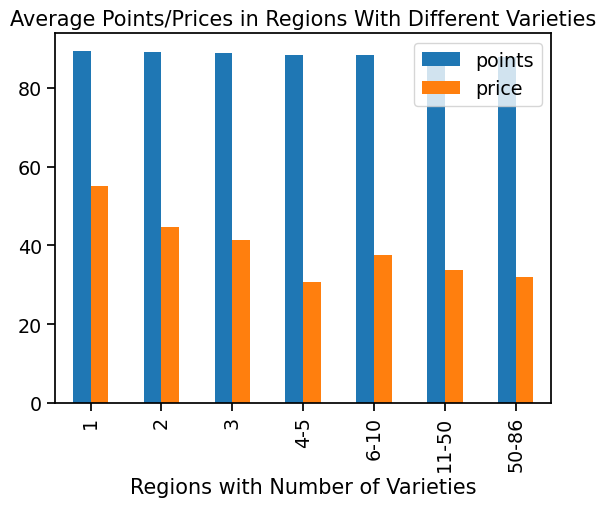

In [39]:
points = [0,1,2,3,5,10,50,100]
regions['part'] = pd.cut(regions['num_var'], bins=points,labels=False)


partitions = regions['part'].unique()

result = []

for partition in partitions:
    part = regions[regions['part'] == partition]


    df3 = data[data['region_1'].isin(part['region_1'])][['region_1','points','price']]#.mean()
    #df3['num_var'] = partition['num_var']
    #df3= df3.dropna()
    df3 = df3.mean()
    result.append(df3)

bp = pd.DataFrame(result[::-1]).plot.bar()

bp.set_title("Average Points/Prices in Regions With Different Varieties")
bp.set_xlabel("Regions with Number of Varieties")
bp.set_xticklabels(['1', '2', '3' , '4-5', '6-10', '11-50' , '50-86'])

## Reviews vs Occurences

Average title has 1.09 occurence.

In [40]:
data.groupby(['variety', 'title']).count().describe()['country']

count    119089.000000
mean          1.090840
std           0.305511
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          11.000000
Name: country, dtype: float64

There are only 12 titles with more than 5 occurence.

In [41]:
asdf = data.groupby(['variety', 'title']).count()
asdf[ asdf['points'] > 5].shape[0]

12

## Most common varieties

,Number of Occurence
count,756.000000
mean,341.546296
std,1933.399855
min,0.000000
25%,3.000000
50%,9.000000
75%,47.250000
max,26415.000000


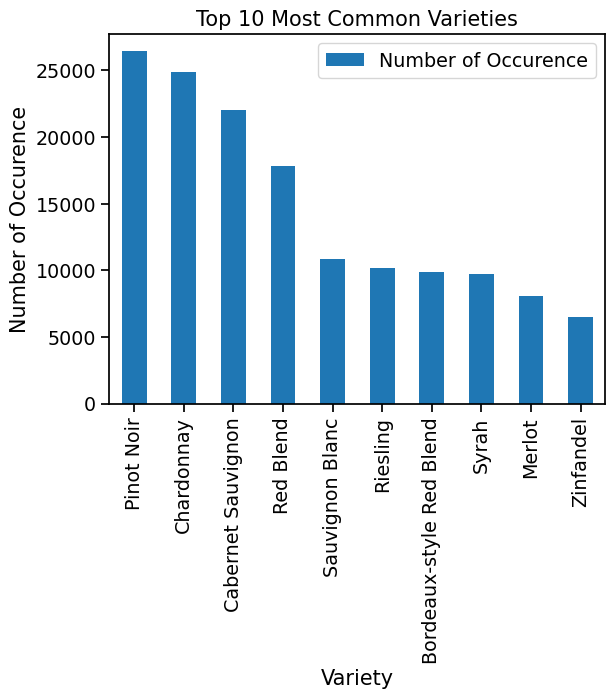

In [42]:
df = data[["variety","price"]]
df = df.groupby(["variety"]).count().sort_values(['price'], ascending=False)
df = df.rename(columns= {"price":"Number of Occurence"})
bp = df[:10].plot.bar()
# set title
bp.set_title("Top 10 Most Common Varieties")
bp.set_xlabel("Variety")
bp.set_ylabel("Number of Occurence")

df.describe()

## Regions with the highest occurence of most popular variety

count     286.000000
mean       87.062937
std       307.887658
min         1.000000
25%         3.000000
50%         8.000000
75%        38.000000
max      3065.000000
Name: popularity, dtype: float64

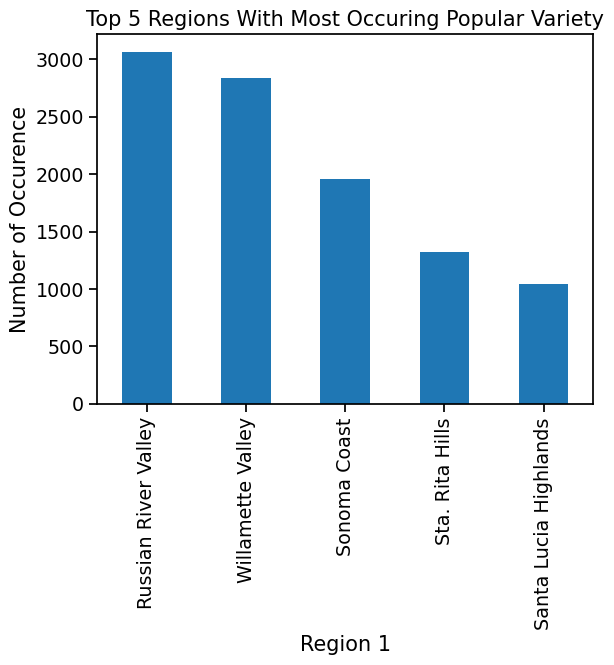

In [43]:
Best_N_Varieties = 1 #Change to number of best varieties to consider

wines = df.index.to_list()[:Best_N_Varieties]

bpp = data[ data['variety'].isin(wines)]

bp = bpp.groupby(["region_1"]).count().rename(columns= {"country":"popularity"})['popularity'].sort_values(ascending=False)[:5].plot.bar()
# set title
bp.set_title("Top 5 Regions With Most Occuring Popular Variety")
bp.set_xlabel("Region 1")
bp.set_ylabel("Number of Occurence")

bpp.groupby("region_1").count().rename(columns= {"country":"popularity"})['popularity'].sort_values(ascending=False).describe()

## Which wine variety has the best quality/price rate?

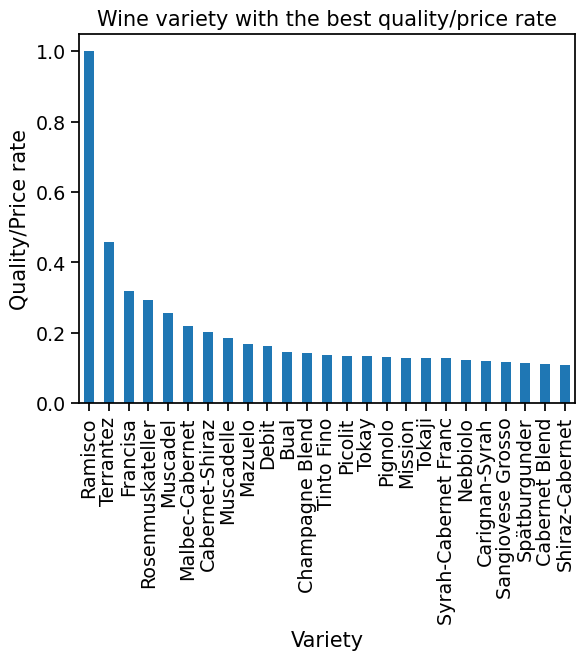

The wine variety with the best quality/price rate was Ramisco


In [44]:
# for every year, calculate the average points
variety_points = data.groupby('variety')['points'].mean()

variety_prices = data.groupby('variety')['price'].mean()

# price / points
country_price_points = variety_prices / variety_points
# normalize
country_price_points = (country_price_points - country_price_points.min()) / (country_price_points.max() - country_price_points.min())

# plot top 25 country_price_points yearly points 
country_price_points.sort_values(ascending=False).head(25).plot(kind='bar')
plt.title('Wine variety with the best quality/price rate')
plt.xlabel('Variety')
plt.ylabel('Quality/Price rate')
plt.show()

# print best year
print("The wine variety with the best quality/price rate was " + str(country_price_points.idxmax()))

# More exploration

## What was a good wine year?

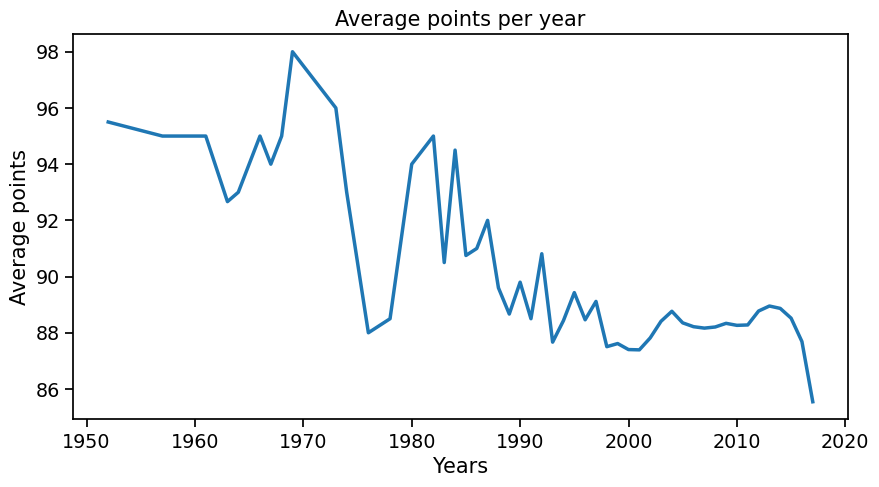

The best year for wine was 1969


count    51.000000
mean     90.430860
std       3.014086
min      85.545455
25%      88.271283
50%      88.866971
75%      93.000000
max      98.000000
Name: points, dtype: float64

In [45]:
year_data = data.copy()
year_data = year_data[['title','points']]

# extract the year from the title column and add it to the dataframe
year_data['year'] = year_data['title'].str.extract('(\d{4})', expand=True)
year_data['year'] = pd.to_numeric(year_data['year']).astype('Int64')
year_data = year_data.dropna(subset=['points', 'year'])

# for every year, calculate the average points
yearly_points = year_data.groupby('year')['points'].mean()
# drop years smaller than 1950
yearly_points = yearly_points[yearly_points.index >= 1950]
# drop years larger than 2023
yearly_points = yearly_points[yearly_points.index <= 2023]

# plot the yearly points

plt.figure(figsize=(10, 5))
plt.title('Average points per year')
plt.xlabel('Years')
plt.ylabel('Average points')
plt.plot(yearly_points.index, yearly_points.values)
plt.show()

# print best year
print("The best year for wine was " + str(yearly_points.idxmax()))

yearly_points.describe()

## Which countries have the price/performance rate?

The wine variety with the best quality/price rate was Switzerland


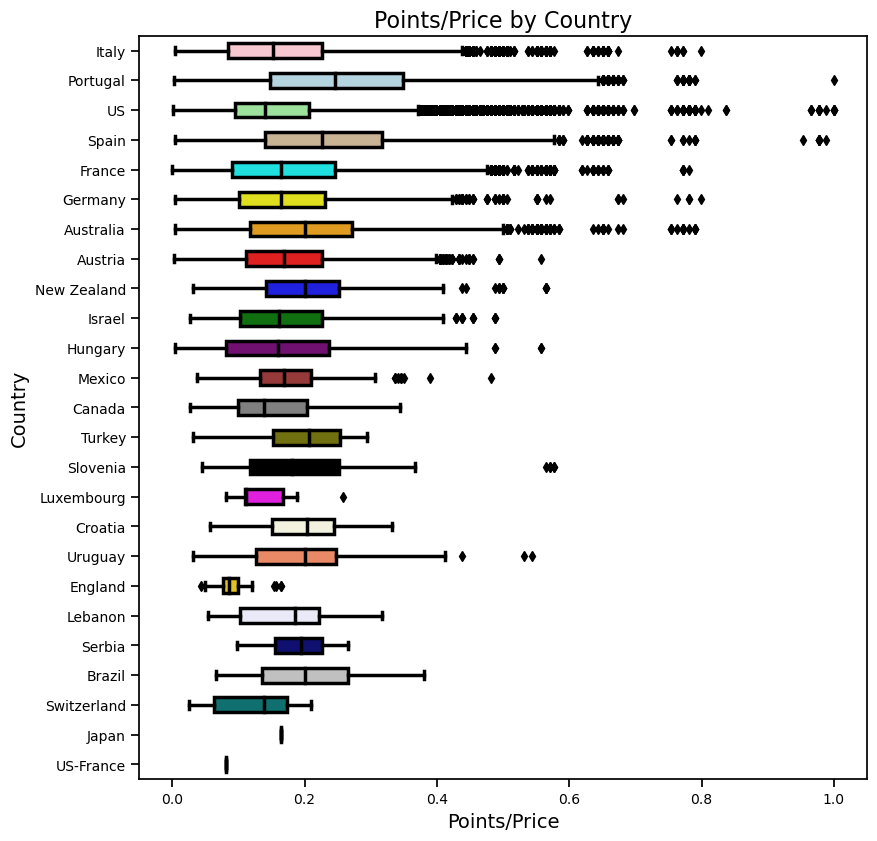

,points,price,points/price
count,255151.000000,232812.000000,232812.000000
mean,88.311157,35.601030,0.175504
std,3.134109,39.857139,0.103048
min,80.000000,4.000000,0.000000
25%,86.000000,17.000000,0.097189
50%,88.000000,26.000000,0.156378
75%,90.000000,42.000000,0.231605
max,100.000000,3300.000000,1.000000


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# for every year, calculate the average points
country_points = data.groupby('country')['points'].mean()

country_prices = data.groupby('country')['price'].mean()

# price / points
country_price_points = country_prices / country_points

# plot country_price_points yearly points
#plt.scatter(country_price_points, country_price_points.index)

#plt.yticks(np.arange(len(country_price_points.index)), country_price_points.index)

#plt.tick_params(axis='y', which='major', labelsize=6)
#plt.tight_layout()
#plt.show()

# print best year
print("The wine variety with the best quality/price rate was " + str(country_price_points.idxmax()))

# horizontal box plot of points/price by country
# add new column for points/price
new_data = data.copy()
new_data['points/price'] = new_data['points'] / new_data['price']

# normalize points/price
new_data['points/price'] = (new_data['points/price'] - new_data['points/price'].min()) / (new_data['points/price'].max() - new_data['points/price'].min())

# select top 25
new_data = new_data[new_data['country'].isin(country_price_points.sort_values(ascending=False).head(25).index)]

colors = ['pink', 'lightblue', 'lightgreen', 'tan', 'cyan', 'yellow', 'orange', 'red', 'blue', 'green', 'purple', 'brown', 'gray', 'olive', 'black', 'magenta', 'beige', 'coral', 'gold', 'lavender', 'navy', 'silver', 'teal', 'lime', 'maroon']

bplot = sns.boxplot(data=new_data, x='points/price', y='country', width=0.5, palette=colors)
bplot.axes.set_title("Points/Price by Country",fontsize=16)
bplot.set_xlabel("Points/Price",fontsize=14)
bplot.set_ylabel("Country",fontsize=14)
bplot.tick_params(labelsize=10)
# resize to fit labels
bplot.figure.tight_layout()
# increase figure size
bplot.figure.set_size_inches(10, 10)

plt.show()

new_data.describe()

## Which countries have irregular quality/price rate?

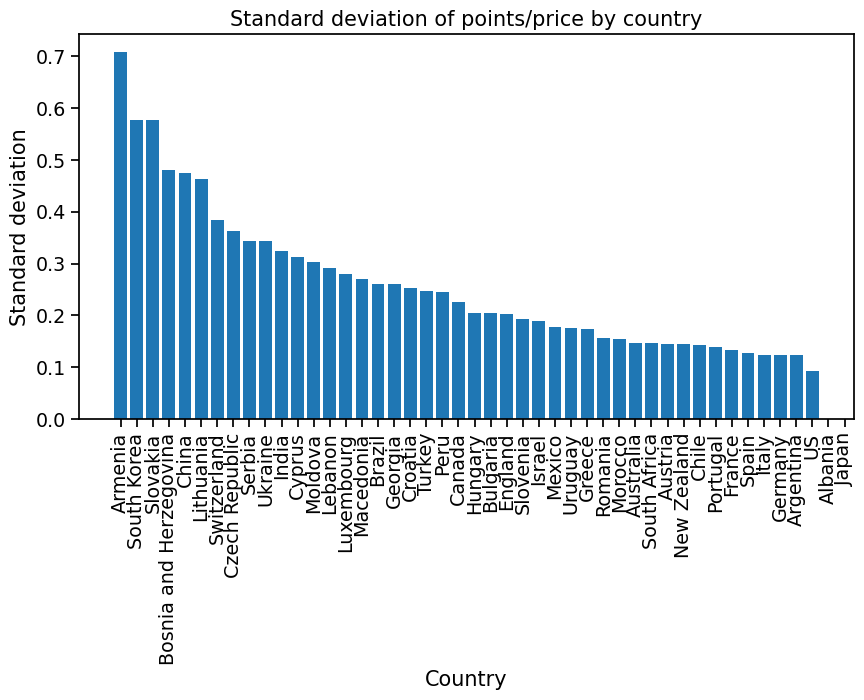

In [47]:
# add new column for points/price
new_data = data.copy()
new_data.dropna(subset=['points', 'price'], inplace=True)
new_data['points/price'] = new_data['points'] / new_data['price']

# normalize points/price by country
new_data['points/price'] = new_data.groupby('country')['points/price'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# get std deviaton of points/price by country
std = new_data.groupby('country')['points/price'].std()

# order by std deviaton
std = std.sort_values(ascending=False)

# plot std deviaton of points/price by country
plt.figure(figsize=(10, 5))
plt.title('Standard deviation of points/price by country')
plt.xlabel('Country')
plt.ylabel('Standard deviation')
plt.bar(std.index, std.values)
# rotate x labels
plt.xticks(rotation=90)
plt.show()

## Which countries have irregularities in the wine quality?

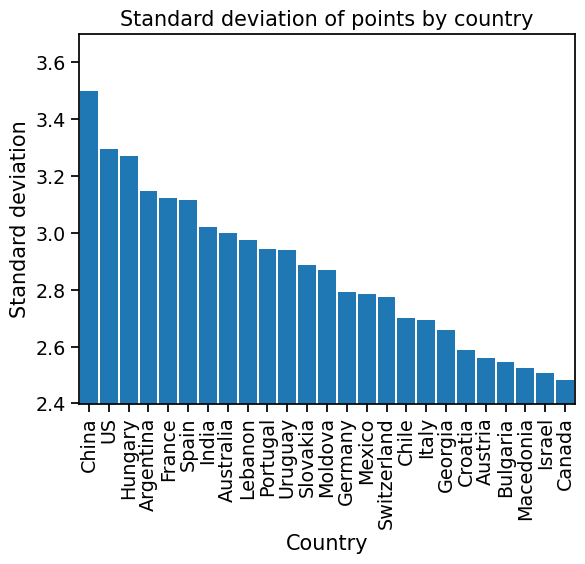

,points,price
count,280901.000000,258210.000000
mean,88.146934,34.177162
std,3.151528,38.611708
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,3300.000000


In [48]:
# std deviation for each country
std_data = data.copy()
country_std = std_data.groupby('country')['points'].std()
# plot the std deviation bar cart
# top 25
country_std = country_std.sort_values(ascending=False).head(25)
country_std.plot.bar()
# make the bars wider
plt.bar(country_std.index, country_std.values, width=0.9)
# limit bar height from 2.5 to max
plt.ylim(2.4, country_std.max()+0.2)
plt.title('Standard deviation of points by country')
plt.xlabel('Country')
plt.ylabel('Standard deviation')
plt.show()

std_data.describe()

## Which region_2 have irregularities in the wine quality?

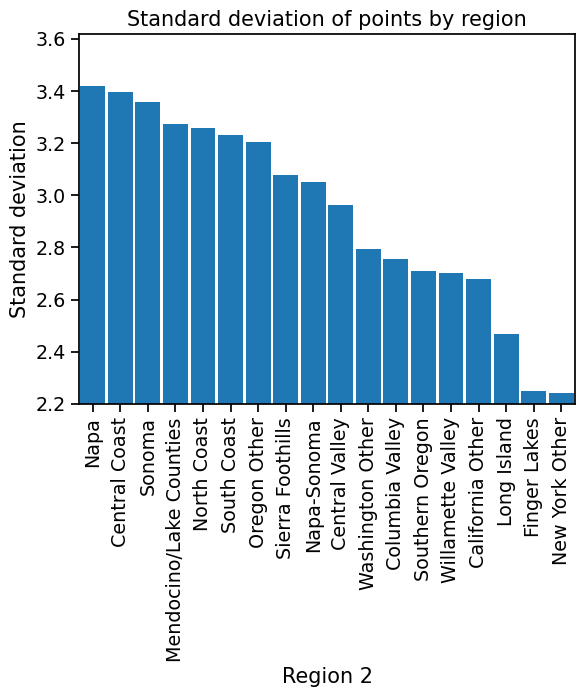

,points,price
count,111464.000000,110996.000000
mean,88.211530,35.235495
std,3.292707,26.281250
min,80.000000,4.000000
25%,86.000000,20.000000
50%,88.000000,30.000000
75%,91.000000,45.000000
max,100.000000,2013.000000


In [49]:
# std deviation for each country
std_data = data.copy()
std_data.dropna(subset=['points', 'region_2'], inplace=True)
region_std = std_data.groupby('region_2')['points'].std()
# plot the std deviation bar cart
# top 25
region_std = region_std.sort_values(ascending=False).head(25)
region_std.plot.bar()
# make the bars wider
plt.bar(region_std.index, region_std.values, width=0.9)
# limit bar height from 2.5 to max
plt.ylim(2.2, region_std.max()+0.2)
plt.title('Standard deviation of points by region')
plt.xlabel('Region 2')
plt.ylabel('Standard deviation')
plt.show()

std_data.describe()

## Which country on average produces the best wines

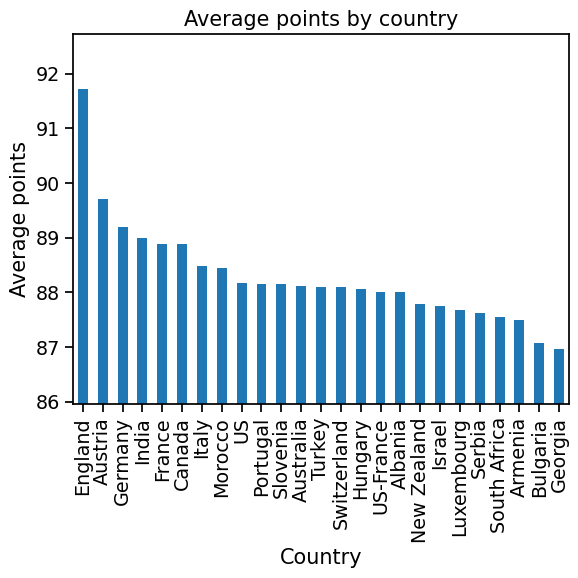

The best country for wine was England


count    25.000000
mean     88.281327
std       0.960084
min      86.961240
25%      87.752423
50%      88.091549
75%      88.481147
max      91.722892
Name: points, dtype: float64

In [50]:
# for every year, calculate the average points
country_points = data.groupby('country')['points'].mean()

# plot the yearly points
country_points = country_points.sort_values(ascending=False).head(25)

country_points.plot.bar()

# scale the y axis according to min and max points
plt.ylim(country_points.min() - 1, country_points.max() + 1)
plt.title('Average points by country')
plt.xlabel('Country')
plt.ylabel('Average points')
plt.show()

# print best year
print("The best country for wine was " + str(country_points.idxmax()))

country_points.describe()

## Which province average produces the best wines?

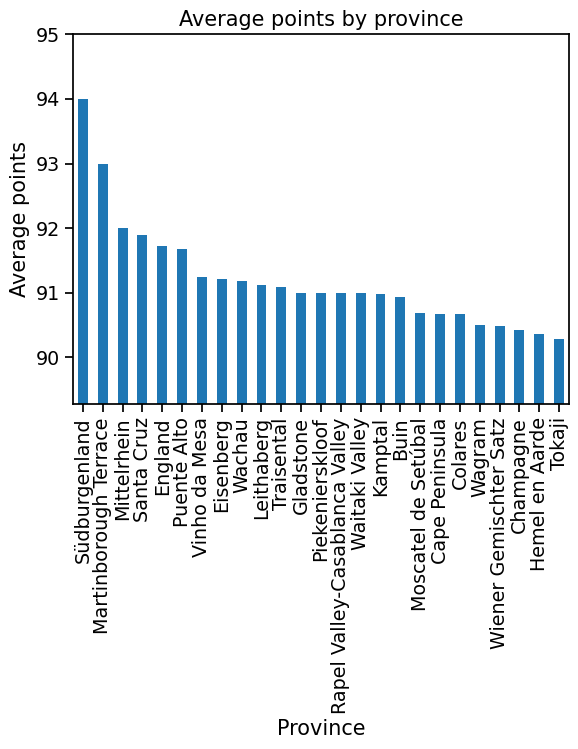

The best province for wine was Südburgenland


In [51]:
# for every year, calculate the average points
province_points = data.groupby('province')['points'].mean()

# plot the yearly points bar chart for the top 25 provinces
province_points.nlargest(25).plot.bar()
# scale the y axis according to min and max points
plt.ylim(province_points.nlargest(25).min() - 1, province_points.nlargest(25).max() + 1)
# order smallest to largest
plt.gca()
plt.title('Average points by province')
plt.xlabel('Province')
plt.ylabel('Average points')
plt.show()

# print best year
print("The best province for wine was " + str(province_points.idxmax()))

# What is the best model?

In [52]:
from sklearn.metrics import classification_report
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score

## Gradient boosting classifier

In [53]:
grad_data = data.dropna(subset=['price'])
X = grad_data.drop(['points'],axis=1)
y = grad_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions))


Accuracy: 0.19880373510047764
              precision    recall  f1-score   support

          80       0.18      0.03      0.05       115
          81       0.62      0.05      0.10       193
          82       0.25      0.06      0.09       514
          83       0.24      0.05      0.08       782
          84       0.21      0.13      0.16      1460
          85       0.22      0.13      0.16      1846
          86       0.23      0.11      0.15      2349
          87       0.21      0.46      0.28      3131
          88       0.20      0.24      0.22      2884
          89       0.19      0.03      0.05      2059
          90       0.19      0.32      0.24      2589
          91       0.19      0.13      0.15      1780
          92       0.18      0.24      0.20      1529
          93       0.18      0.15      0.16      1002
          94       0.19      0.09      0.12       581
          95       0.20      0.04      0.06       259
          96       0.20      0.09      0.12        

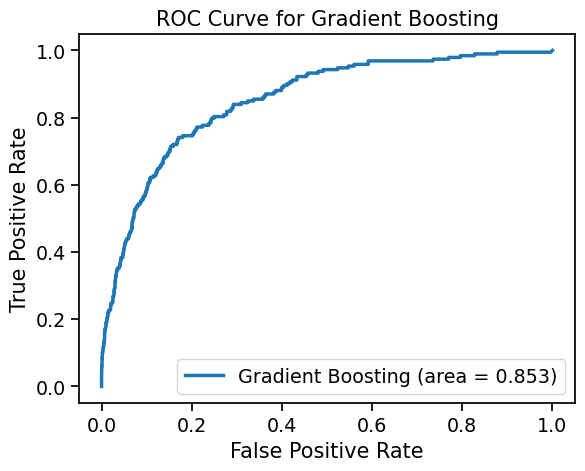

In [54]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_grad = classifier.predict_proba(X_valid)[:,1]

curve_grad = roc_curve(y_valid, y_grad, pos_label=classifier.classes_[1])

auc_grad= auc(curve_grad[0], curve_grad[1])

boostplot = plt.plot(curve_grad[0], curve_grad[1], label='Gradient Boosting (area = %0.3f)'% auc_grad)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

## Logistic regression

In [55]:
logistic_data = data.dropna(subset=['price'])
X = logistic_data.drop(['points'],axis=1)
y = logistic_data['points'].values


# logistic regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions, zero_division=1))

Accuracy: 0.172511725977882
              precision    recall  f1-score   support

          80       1.00      0.00      0.00       115
          81       1.00      0.00      0.00       193
          82       1.00      0.00      0.00       514
          83       1.00      0.00      0.00       782
          84       0.18      0.15      0.17      1460
          85       0.19      0.04      0.07      1846
          86       0.18      0.05      0.08      2349
          87       0.17      0.65      0.27      3131
          88       0.17      0.14      0.15      2884
          89       0.21      0.00      0.01      2059
          90       0.17      0.31      0.22      2589
          91       0.16      0.02      0.04      1780
          92       0.16      0.14      0.15      1529
          93       0.16      0.07      0.10      1002
          94       0.23      0.05      0.09       581
          95       0.17      0.03      0.05       259
          96       0.33      0.03      0.06        94

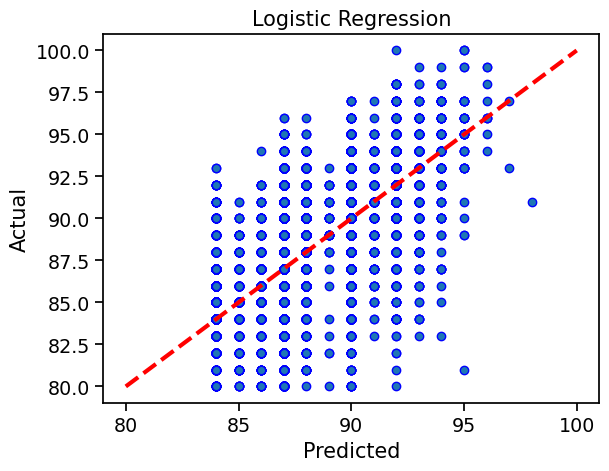

In [56]:
fig, ax = plt.subplots()
ax.scatter(predictions, y_valid, edgecolors=(0, 0, 1))
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Logistic Regression')
plt.show()

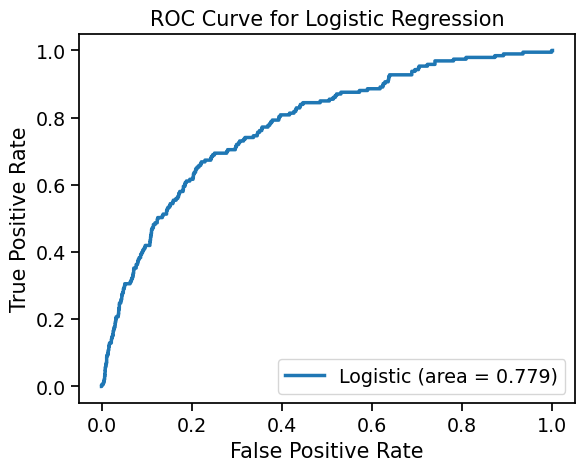

In [57]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_logistic = classifier.predict_proba(X_valid)[:,1]

curve_logistic = roc_curve(y_valid, y_logistic, pos_label=classifier.classes_[1])

auc_logistic = auc(curve_logistic[0], curve_logistic[1])

logisticplot = plt.plot(curve_logistic[0], curve_logistic[1], label='Logistic (area = %0.3f)'% auc_logistic)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Gaussian naive bayes

In [58]:
from sklearn.naive_bayes import GaussianNB


gaus_data = data.dropna(subset=['price'])
X = gaus_data.drop(['points'],axis=1)
y = gaus_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

# naive bayes
classifier = GaussianNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions, zero_division=1))

Accuracy: 0.15624596583329747
              precision    recall  f1-score   support

          80       1.00      0.00      0.00       115
          81       1.00      0.00      0.00       193
          82       0.22      0.02      0.04       514
          83       1.00      0.00      0.00       782
          84       0.14      0.19      0.16      1460
          85       0.13      0.02      0.03      1846
          86       0.15      0.17      0.16      2349
          87       0.16      0.64      0.25      3131
          88       0.14      0.01      0.02      2884
          89       0.10      0.01      0.02      2059
          90       0.16      0.20      0.18      2589
          91       0.18      0.03      0.04      1780
          92       0.15      0.09      0.12      1529
          93       0.17      0.07      0.10      1002
          94       0.23      0.06      0.10       581
          95       0.15      0.04      0.07       259
          96       0.20      0.10      0.13        

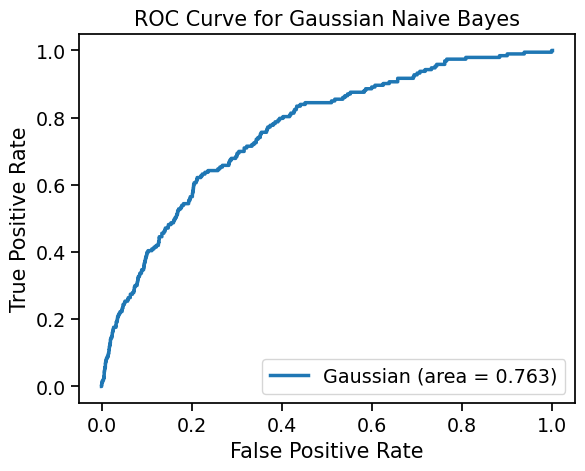

In [59]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_naive = classifier.predict_proba(X_valid)[:,1]

curve_naive = roc_curve(y_valid, y_naive, pos_label=classifier.classes_[1])

auc_naive= auc(curve_naive[0], curve_naive[1])

gnbplot = plt.plot(curve_naive[0], curve_naive[1], label='Gaussian (area = %0.3f)'% auc_naive)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## Multinomial naive bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB

multi_data = data.dropna(subset=['price'])
X = multi_data.drop(['points'],axis=1)
y = multi_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions))

Accuracy: 0.044020827057962904
              precision    recall  f1-score   support

          80       0.01      0.02      0.02       115
          81       0.00      0.00      0.00       193
          82       0.05      0.05      0.05       514
          83       0.04      0.25      0.08       782
          84       0.07      0.11      0.08      1460
          85       0.07      0.03      0.04      1846
          86       0.15      0.01      0.02      2349
          87       0.15      0.00      0.00      3131
          88       0.13      0.06      0.09      2884
          89       0.22      0.00      0.01      2059
          90       0.25      0.00      0.00      2589
          91       0.08      0.15      0.10      1780
          92       0.14      0.00      0.01      1529
          93       0.02      0.00      0.00      1002
          94       0.04      0.14      0.06       581
          95       0.01      0.01      0.01       259
          96       0.01      0.13      0.01       

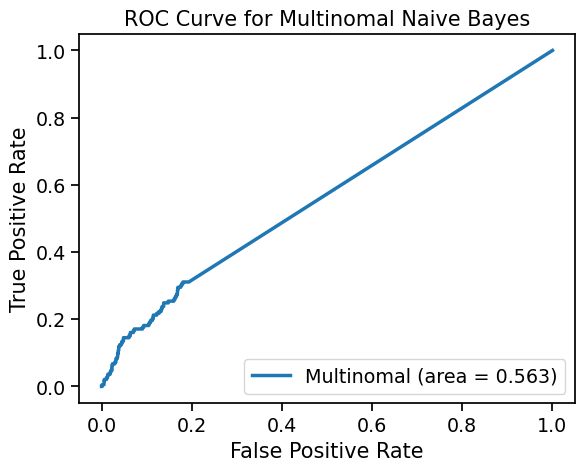

In [61]:
## ROC curve of model
from sklearn.metrics import roc_curve, auc

y_multi = classifier.predict_proba(X_valid)[:,1]

curve_multi = roc_curve(y_valid, y_multi, pos_label=classifier.classes_[1])

auc_multi= auc(curve_multi[0], curve_multi[1])

multiplot = plt.plot(curve_multi[0], curve_multi[1], label='Multinomal (area = %0.3f)'% auc_multi)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multinomal Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## Support vector machine

In [62]:
from sklearn.naive_bayes import GaussianNB


gaus_data = data.dropna(subset=['price'])
X = gaus_data.drop(['points'],axis=1)
y = gaus_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

# naive bayes
classifier = GaussianNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions, zero_division=1))

Accuracy: 0.15624596583329747
              precision    recall  f1-score   support

          80       1.00      0.00      0.00       115
          81       1.00      0.00      0.00       193
          82       0.22      0.02      0.04       514
          83       1.00      0.00      0.00       782
          84       0.14      0.19      0.16      1460
          85       0.13      0.02      0.03      1846
          86       0.15      0.17      0.16      2349
          87       0.16      0.64      0.25      3131
          88       0.14      0.01      0.02      2884
          89       0.10      0.01      0.02      2059
          90       0.16      0.20      0.18      2589
          91       0.18      0.03      0.04      1780
          92       0.15      0.09      0.12      1529
          93       0.17      0.07      0.10      1002
          94       0.23      0.06      0.10       581
          95       0.15      0.04      0.07       259
          96       0.20      0.10      0.13        

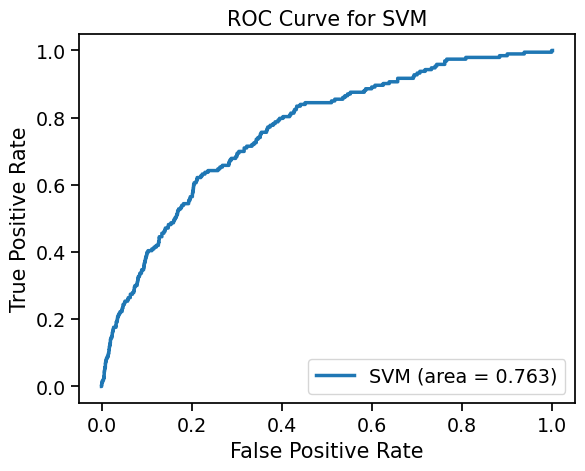

In [63]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_svm = classifier.predict_proba(X_valid)[:,1]

curve_svm = roc_curve(y_valid, y_svm, pos_label=classifier.classes_[1])

auc_svm = auc(curve_svm[0], curve_svm[1])

svmplot = plt.plot(curve_svm[0], curve_svm[1], label='SVM (area = %0.3f)'% auc_svm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()

## Random forest classifier

In [64]:
from sklearn.ensemble import RandomForestClassifier

randomforest_data = data.dropna(subset=['price'])
X = randomforest_data.drop(['points'],axis=1)
y = randomforest_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions))


Accuracy: 0.5453763070700116
              precision    recall  f1-score   support

          80       0.73      0.48      0.58       115
          81       0.70      0.49      0.57       193
          82       0.62      0.48      0.54       514
          83       0.65      0.51      0.57       782
          84       0.59      0.54      0.57      1460
          85       0.59      0.55      0.57      1846
          86       0.57      0.57      0.57      2349
          87       0.53      0.62      0.57      3131
          88       0.53      0.56      0.55      2884
          89       0.55      0.51      0.53      2059
          90       0.51      0.58      0.54      2589
          91       0.51      0.49      0.50      1780
          92       0.51      0.52      0.52      1529
          93       0.52      0.49      0.50      1002
          94       0.51      0.48      0.50       581
          95       0.56      0.46      0.50       259
          96       0.60      0.38      0.47        9

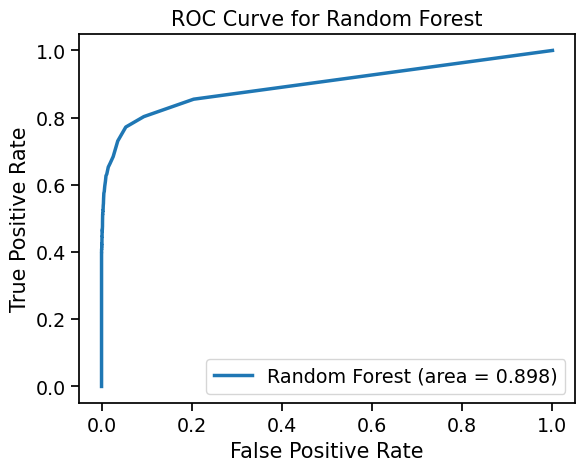

In [65]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_random = classifier.predict_proba(X_valid)[:,1]

curve_random = roc_curve(y_valid, y_random, pos_label=classifier.classes_[1])

auc_random = auc(curve_random[0], curve_random[1])

randomplot = plt.plot(curve_random[0], curve_random[1], label='Random Forest (area = %0.3f)'% auc_random)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

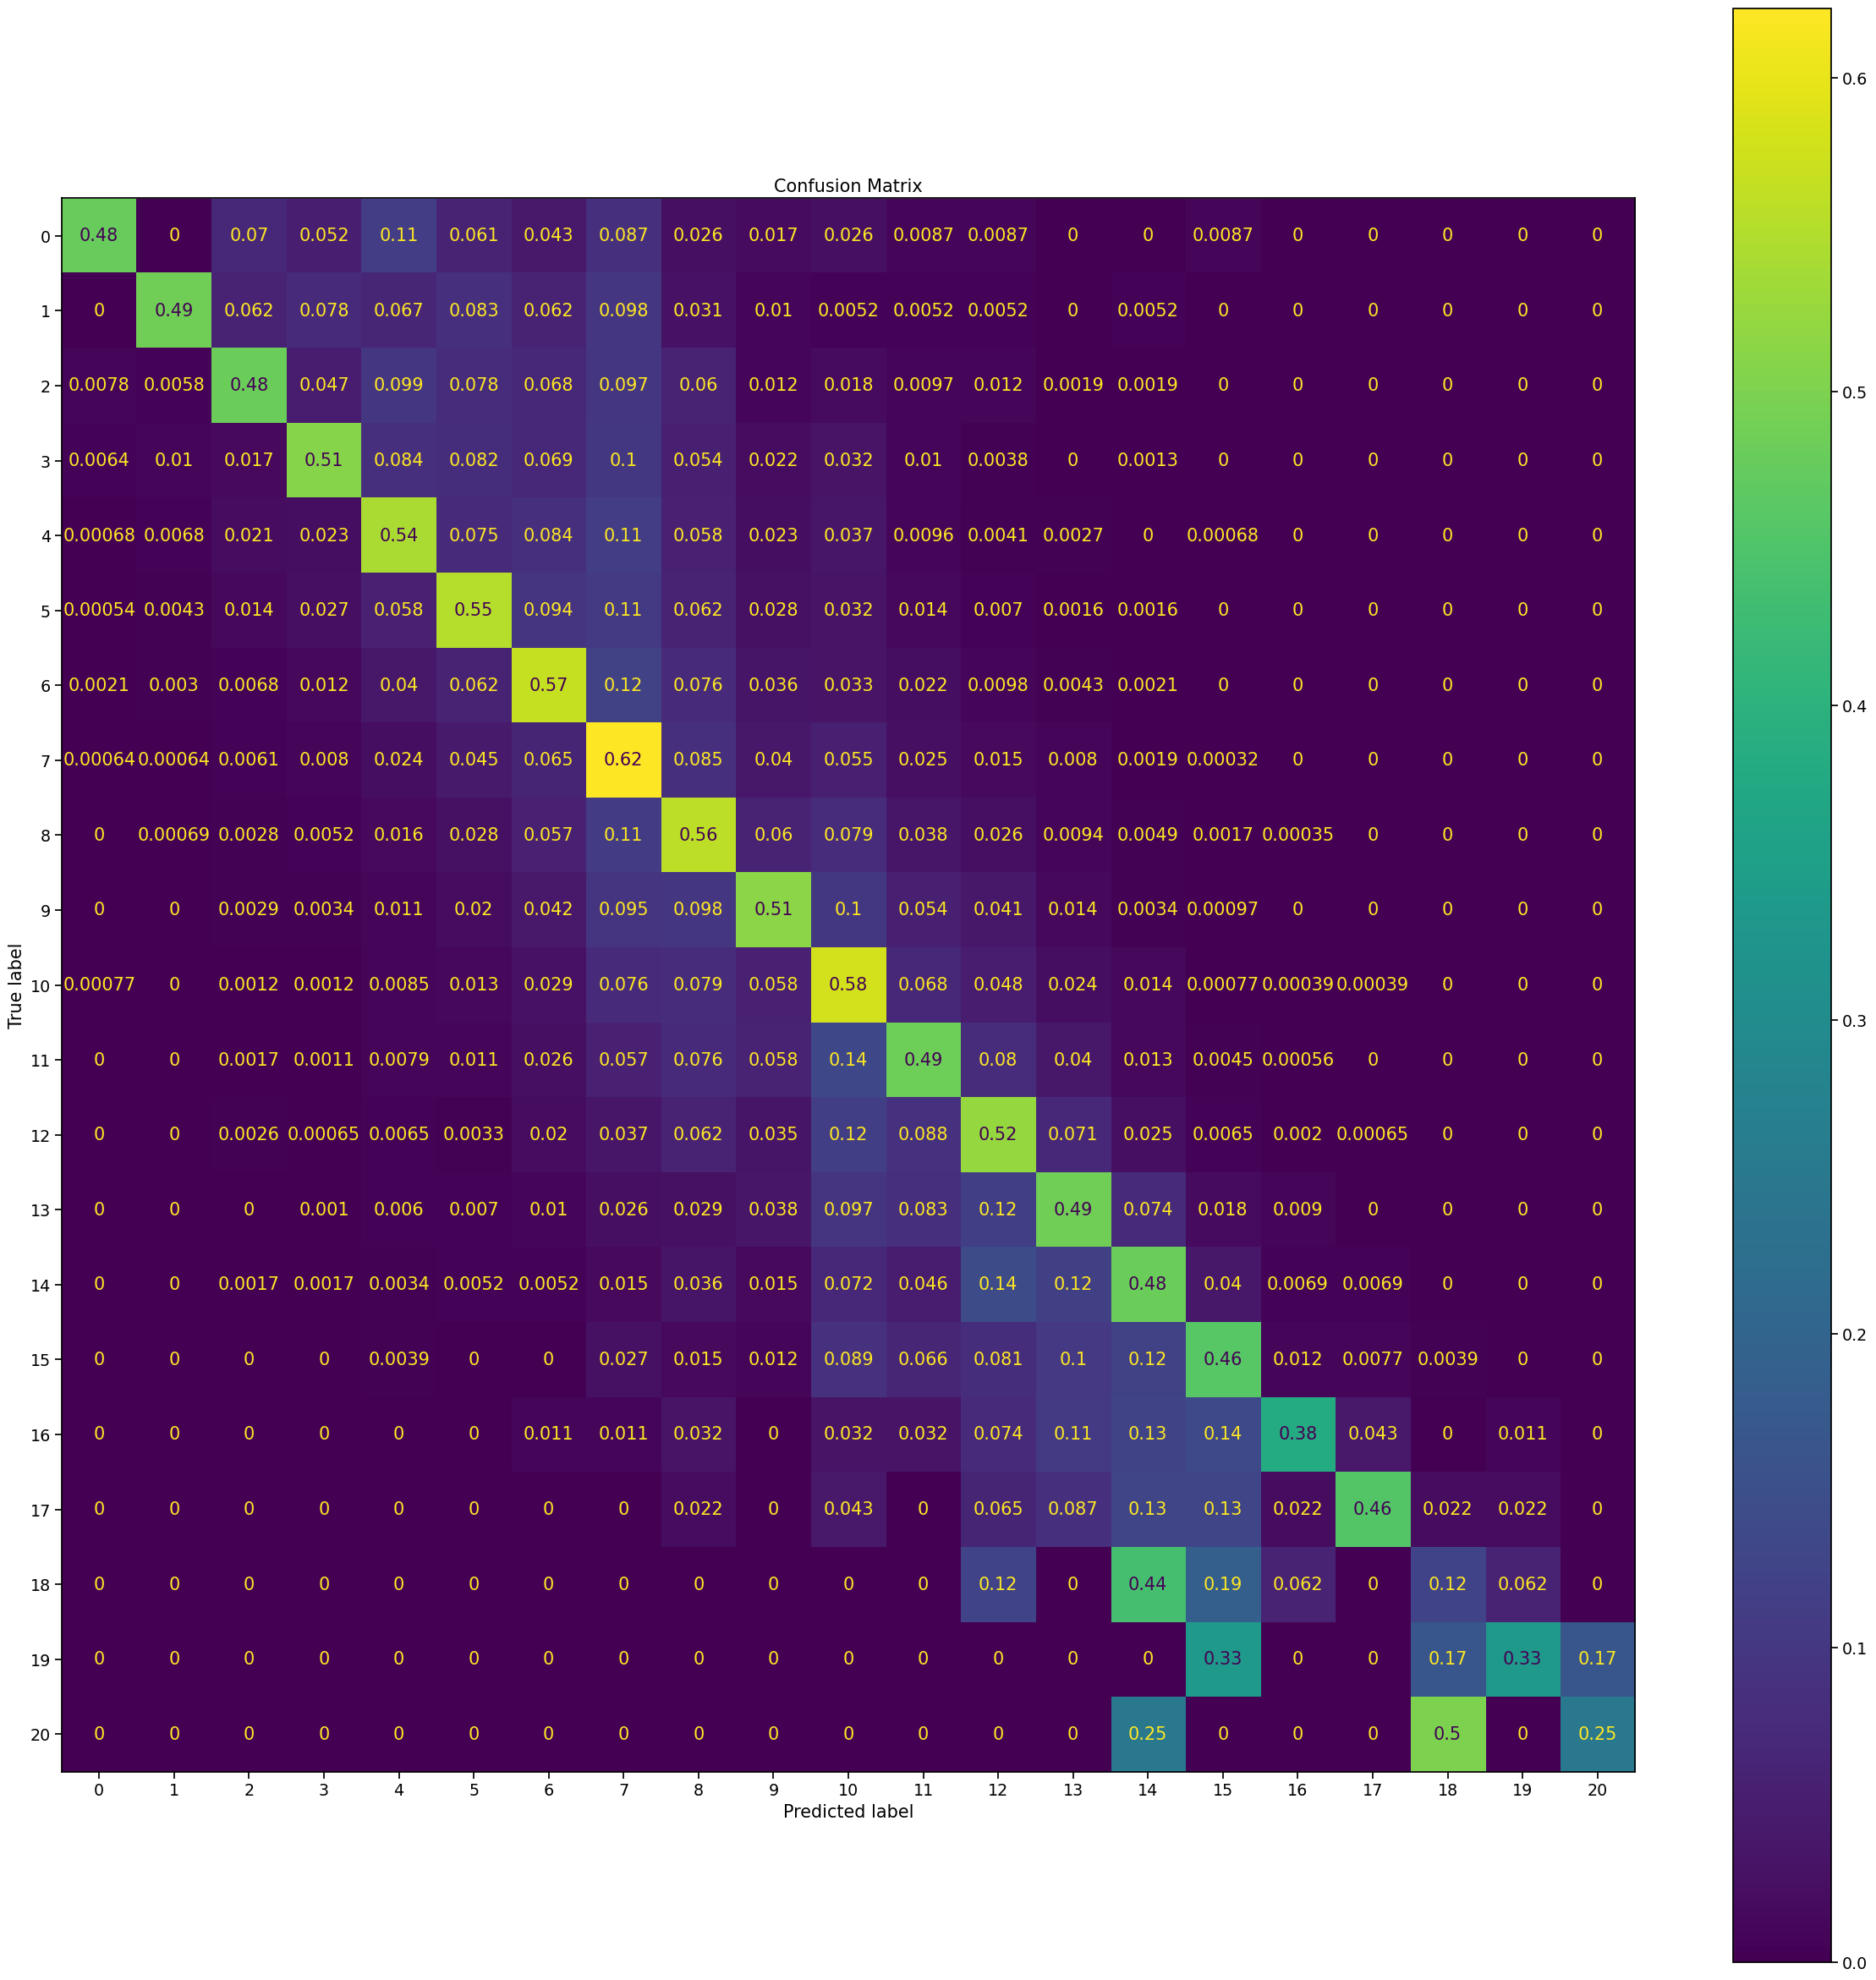

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# plot confusion matrix
confusion_matrix(y_valid, predictions, normalize='true')

# confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_valid, predictions, normalize='true')).plot()
plt.gcf().set_size_inches(30, 30)
#limit to 2 decimal places
plt.grid(False)
cm_display.ax_.set_title('Confusion Matrix')

## Decision tree classifier

In [67]:
from sklearn.tree import DecisionTreeClassifier

decision_data = data.dropna(subset=['price'])
X = decision_data.drop(['points'],axis=1)
y = decision_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions, zero_division=1))

Accuracy: 0.5388786092344765
              precision    recall  f1-score   support

          80       0.55      0.57      0.56       115
          81       0.57      0.55      0.56       193
          82       0.55      0.53      0.54       514
          83       0.58      0.56      0.57       782
          84       0.57      0.56      0.56      1460
          85       0.56      0.54      0.55      1846
          86       0.57      0.57      0.57      2349
          87       0.58      0.58      0.58      3131
          88       0.55      0.55      0.55      2884
          89       0.51      0.52      0.52      2059
          90       0.53      0.54      0.53      2589
          91       0.49      0.48      0.49      1780
          92       0.50      0.51      0.50      1529
          93       0.48      0.47      0.48      1002
          94       0.48      0.49      0.48       581
          95       0.53      0.47      0.49       259
          96       0.47      0.45      0.46        9

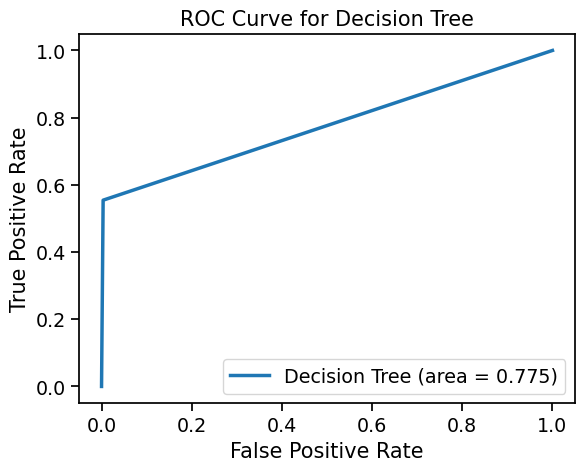

In [68]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_decision = classifier.predict_proba(X_valid)[:,1]

curve_decision = roc_curve(y_valid, y_decision, pos_label=classifier.classes_[1])

auc_decision = auc(curve_decision[0], curve_decision[1])

decisionplot = plt.plot(curve_decision[0], curve_decision[1], label='Decision Tree (area = %0.3f)'% auc_decision)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

## Extra trees classifier

In [69]:
from sklearn.tree import ExtraTreeClassifier

decision_data = data.dropna(subset=['price'])
X = decision_data.drop(['points'],axis=1)
y = decision_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

# naive bayes
classifier = ExtraTreeClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions, zero_division=1))

Accuracy: 0.5095744223073282
              precision    recall  f1-score   support

          80       0.51      0.51      0.51       115
          81       0.51      0.49      0.50       193
          82       0.51      0.51      0.51       514
          83       0.52      0.51      0.51       782
          84       0.53      0.50      0.51      1460
          85       0.52      0.52      0.52      1846
          86       0.53      0.54      0.54      2349
          87       0.56      0.56      0.56      3131
          88       0.52      0.52      0.52      2884
          89       0.48      0.48      0.48      2059
          90       0.51      0.51      0.51      2589
          91       0.46      0.46      0.46      1780
          92       0.49      0.50      0.50      1529
          93       0.44      0.43      0.43      1002
          94       0.47      0.46      0.47       581
          95       0.41      0.42      0.42       259
          96       0.43      0.43      0.43        9

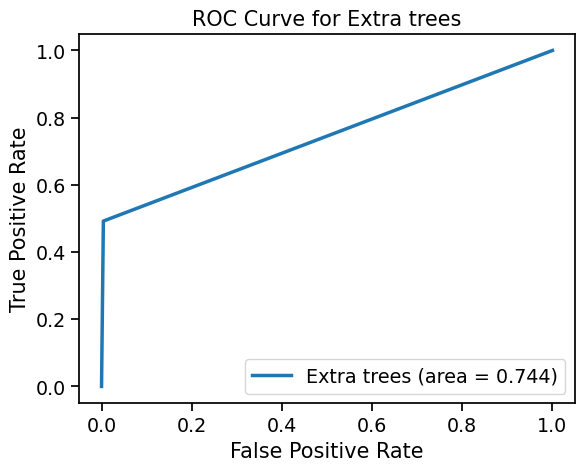

In [70]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_extra = classifier.predict_proba(X_valid)[:,1]

curve_extra = roc_curve(y_valid, y_extra, pos_label=classifier.classes_[1])

auc_extra = auc(curve_extra[0], curve_extra[1])

extraplot = plt.plot(curve_extra[0], curve_extra[1], label='Extra trees (area = %0.3f)'% auc_extra)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extra trees')
plt.legend(loc="lower right")
plt.show()

## K nearest neighbors classifier

In [71]:
# import k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

k_data = data.dropna(subset=['price'])
X = k_data.drop(['points'],axis=1)
y = k_data['points'].values

encoder = LabelEncoder()
for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = encoder.fit_transform(X[column_name])
        else:
            pass




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.1,stratify=y_train, random_state=1)

# naive bayes
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_valid)
print("Accuracy: " + str(accuracy_score(predictions, y_valid)))
print(classification_report(y_valid, predictions, zero_division=1))

Accuracy: 0.1907999483626662
              precision    recall  f1-score   support

          80       0.10      0.18      0.13       115
          81       0.12      0.20      0.15       193
          82       0.14      0.23      0.17       514
          83       0.15      0.22      0.18       782
          84       0.16      0.23      0.18      1460
          85       0.16      0.20      0.18      1846
          86       0.20      0.23      0.21      2349
          87       0.23      0.27      0.25      3131
          88       0.23      0.23      0.23      2884
          89       0.20      0.16      0.18      2059
          90       0.21      0.18      0.19      2589
          91       0.18      0.12      0.15      1780
          92       0.20      0.13      0.16      1529
          93       0.15      0.07      0.10      1002
          94       0.14      0.06      0.08       581
          95       0.20      0.07      0.11       259
          96       0.12      0.03      0.05        9

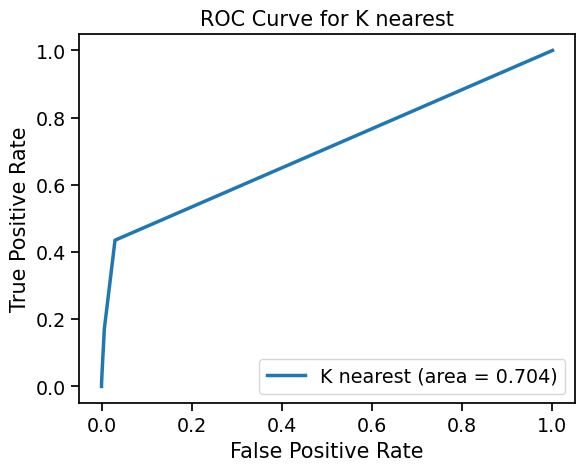

In [72]:
# ROC curve of model
from sklearn.metrics import roc_curve, auc

y_k = classifier.predict_proba(X_valid)[:,1]

curve_k = roc_curve(y_valid, y_k, pos_label=classifier.classes_[1])

auc_k = auc(curve_k[0], curve_k[1])

kplot = plt.plot(curve_k[0], curve_k[1], label='K nearest (area = %0.3f)'% auc_k)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K nearest')
plt.legend(loc="lower right")
plt.show()

## Merged ROC curve

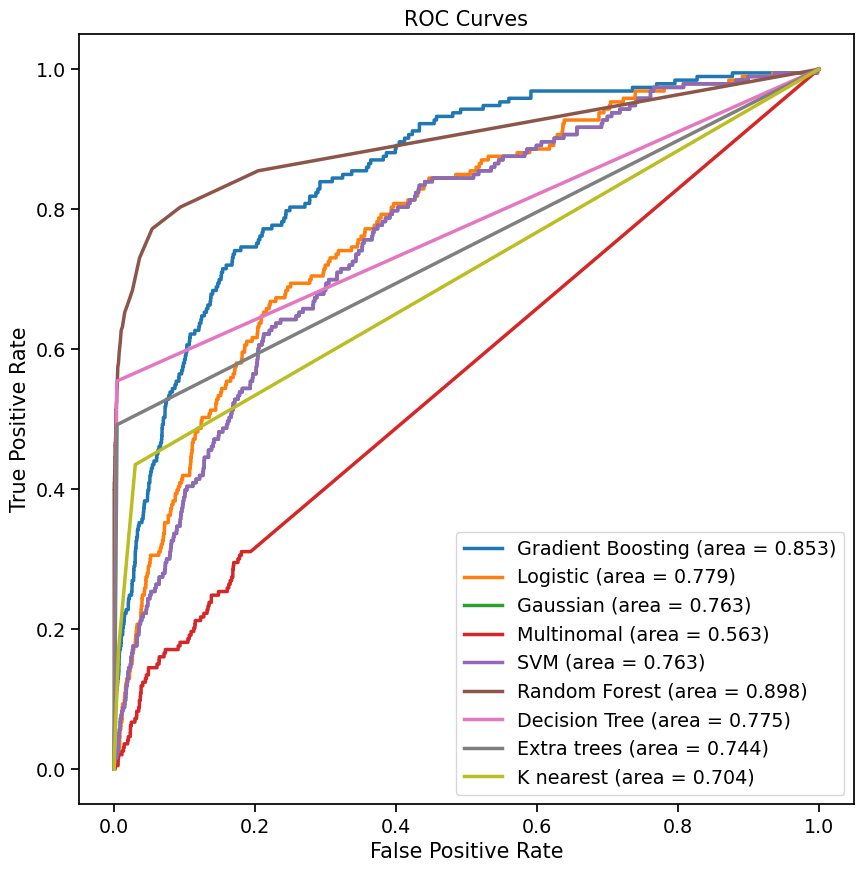

In [73]:
# merge all roc curves
plt.plot(curve_grad[0], curve_grad[1], label='Gradient Boosting (area = %0.3f)'% auc_grad)
plt.plot(curve_logistic[0], curve_logistic[1], label='Logistic (area = %0.3f)'% auc_logistic)
plt.plot(curve_naive[0], curve_naive[1], label='Gaussian (area = %0.3f)'% auc_naive)
plt.plot(curve_multi[0], curve_multi[1], label='Multinomal (area = %0.3f)'% auc_multi)
plt.plot(curve_svm[0], curve_svm[1], label='SVM (area = %0.3f)'% auc_svm)
plt.plot(curve_random[0], curve_random[1], label='Random Forest (area = %0.3f)'% auc_random)
plt.plot(curve_decision[0], curve_decision[1], label='Decision Tree (area = %0.3f)'% auc_decision)
plt.plot(curve_extra[0], curve_extra[1], label='Extra trees (area = %0.3f)'% auc_extra)
plt.plot(curve_k[0], curve_k[1], label='K nearest (area = %0.3f)'% auc_k)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

# resize so the legend fits
plt.gcf().set_size_inches(10, 10)
